In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import os
import sys

C:\Users\jeanb\AppData\Local\Temp\ipykernel_7332\2816450569.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Automated portfolio system
### Currently generates a equally weighted portfolio that has increased by 57.28% since the completion of this project.
### And enhances the portfolio with optimized weights, outputting the final portfolio that has increased by 70.59% since the completion of this project.
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#### Project premise is to use an alpha generator to automatically generate a portfolio that will maximize our gains with respect to risk-taken.
#### An alpha generator is any security that, when added by an investor to an existing portfolio of assets, generates excess returns or returns higher than a pre-selected benchmark without additional risk.
#### I am using the price momentum alpha generator because its calculations are free and easily accessible through yfinance library.

### The SP500 is our benchmark, we retrieve its updated 500 stocks directly from the daily-updated csv from the State Street Global Advisors website.

In [3]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  505 of 505 completed

3 Failed downloads:
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [4]:
# Gets the last date of dataset
# This is our most current price for eah asset, just as a refernce of the prices we are using.
sp500.tail(1) 

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-02,144.210007,14.385,169.009995,180.770004,160.460007,112.065002,91.519897,336.670013,498.654999,195.100006,...,35.380001,105.029999,53.994999,118.889999,32.075001,128.100006,140.330002,128.0,297.204987,164.839996


In [5]:
# Changing the time period and lag will affect the range of the alortithm
time_period = 1260  # 5 years of trading days. (252 trading days per year)
lag = 20 # lag of 20 trading days (1 month)


## Momentum Factors
####  Calculates each sp500 stock scores based on factors.

In [6]:
#how_many_days_back = 0 for current, 1260 for 5 years.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors Result


In [7]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.047756,38.310270,6.323421,0.129017,1.344187e+05
AAL,-0.014979,45.227560,-6.758856,-0.041416,9.211518e+07
AAPL,0.125664,56.740082,13.930166,0.296684,3.001913e+07
ABBV,0.081220,39.017488,10.038283,0.184049,-6.823255e+05
ABNB,NaN,35.754492,-3.993384,-0.018700,1.605194e+06
...,...,...,...,...,...
XYL,0.027467,40.974617,4.490400,0.100375,-3.269496e+05
YUM,0.028919,36.387889,3.497888,0.067010,5.662972e+04
ZBH,-0.000776,33.070161,-0.819867,0.019600,-1.123490e+05


In [8]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

## Z-Score normalizes the data results
### Our portfolio basket is determined by the highest and lowest scores, resulted from the momentum factor calculations.

In [9]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
TSLA    40.048822
MRNA    18.597663
NVDA    17.959795
SMCI    16.400070
NVR     14.973063
ENPH    13.849668
CMG      9.569497
BLDR     9.554473
AMD      9.135823
AZO      9.029042
dtype: float64

Short Basket:
Ticker
VZ     -4.909407
T      -5.016959
PARA   -5.203357
WBA    -5.371552
VTRS   -5.510854
ILMN   -5.539236
WBD    -6.023802
BAX    -6.118734
FIS    -6.226110
VFC    -7.712372
dtype: float64


## Back Test

In [10]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
NVR     18.413273
NVDA    16.831625
AMD     16.663817
ETSY    13.733713
CZR     13.084416
NFLX    12.596197
ALGN    11.295801
PAYC    11.116233
ENPH     8.511594
AMZN     8.180519
dtype: float64
Short Basket Past 5 Years:
Ticker
F      -5.077698
BEN    -5.142967
HWM    -5.210712
CMG    -5.357379
APA    -5.359100
BBWI   -5.530648
SLB    -5.724584
MCK    -5.821487
EQT    -6.488302
GE     -6.842004
dtype: float64


## Graphing Cumulative Returns

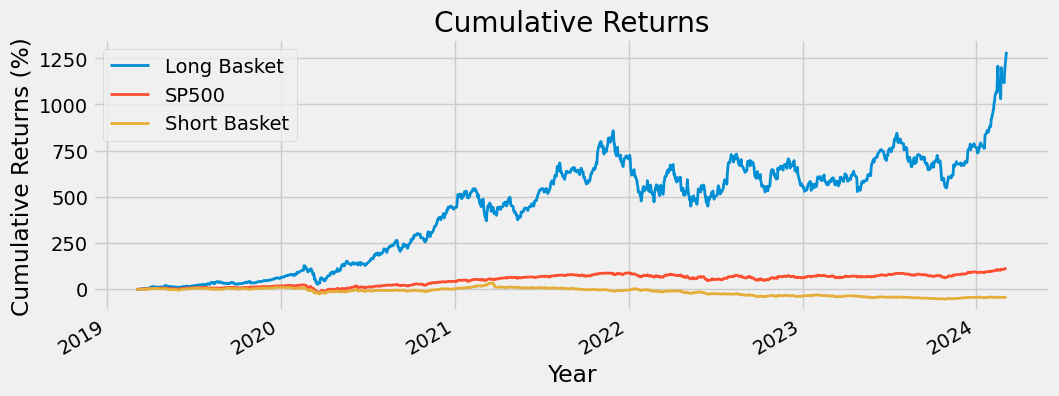

In [11]:
def calculate_cumulative_returns(dataf):
    # Calculate percentage change
    returns = dataf.pct_change()
    # Initialize the first value to 1 (i.e., no change, or 0% return)
    # This is achieved by filling the NaN values resulted from pct_change() with 0
    # and then adding 1 to convert the initial value to 1 for cumprod() calculation
    cumulative_returns = (1 + returns.fillna(0)).cumprod().mean(axis=1)*100
    # To start from 0%, subtract 100 from the entire series
    cumulative_returns = cumulative_returns - 100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns.plot(label='SP500', lw =2)
short_cumulative_returns.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Portfolio stats -- Equally weighted (not final portfolio)

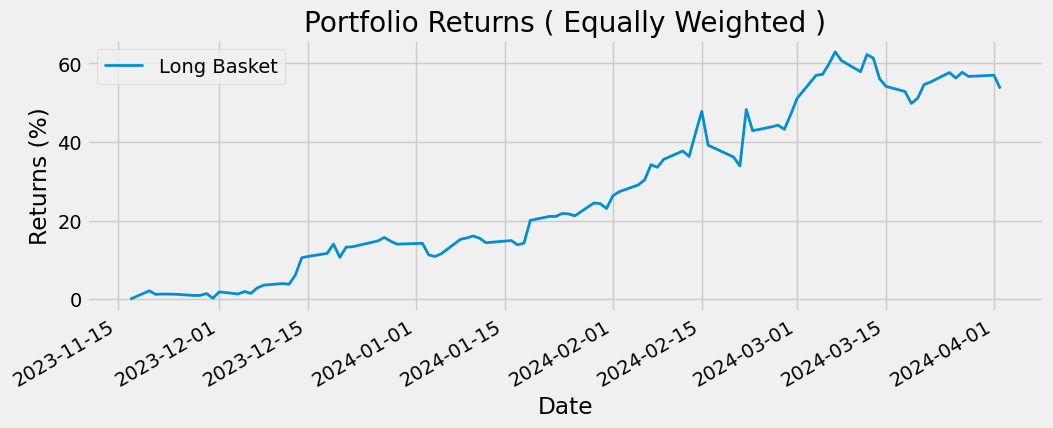

In [12]:
portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
portfolio_returns.plot(label='Long Basket', lw=2) 
plt.legend()
plt.title('Portfolio Returns ( Equally Weighted )')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.show()

In [13]:

portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
print("Portfolio Returns from Project Completion to Current Date:")
print (portfolio_returns)

current_date = datetime.now()
project_completion_date = datetime(2023, 11, 15)

# difference between the two dates
difference_days = current_date - project_completion_date 

# number of weeks
weeks = difference_days.days // 7
print (f"Avegare Weekly Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (portfolio_returns[-1]/weeks)

Portfolio Returns from Project Completion to Current Date:
Date
2023-11-17     0.000000
2023-11-20     2.117890
2023-11-21     1.219445
2023-11-22     1.289684
2023-11-24     1.262074
                ...    
2024-03-26    56.258349
2024-03-27    57.742377
2024-03-28    56.677377
2024-04-01    56.990004
2024-04-02    53.584433
Length: 92, dtype: float64
Avegare Weekly Portfolio Returns from Project Completion to Current Date (19 weeks): 
2.8202333172599854


In [14]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
1285.4745768164225
Short Basket Cumulative Returns: Most current day
-45.57174062958603
SP500 Cumulative Returns: Most current day
112.93466349172573


In [15]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-04-02 Long Basket has outperformed the SP500 by 1172.5399133246967 percentage points
As of 2024-04-02 Short Basket has underperformed the SP500 by -158.50640412131176 percentage points


## Graphing the Back Tested Cumulative Returns

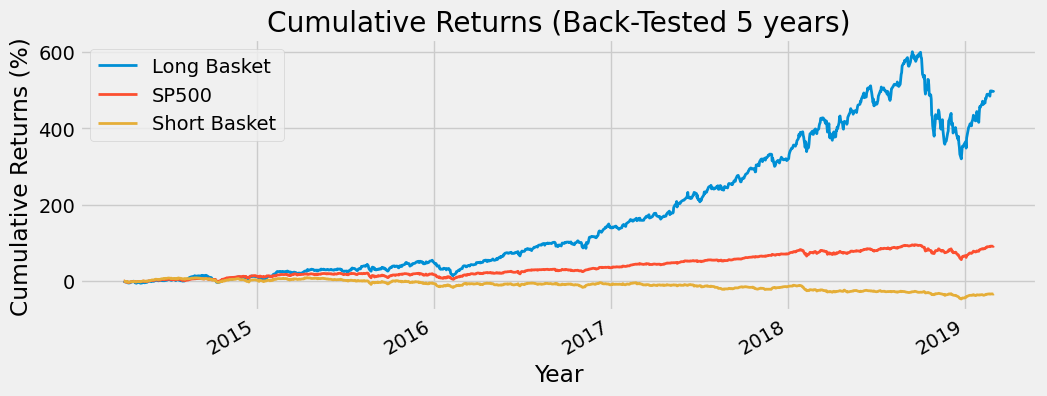

In [16]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested 5 years)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Returns

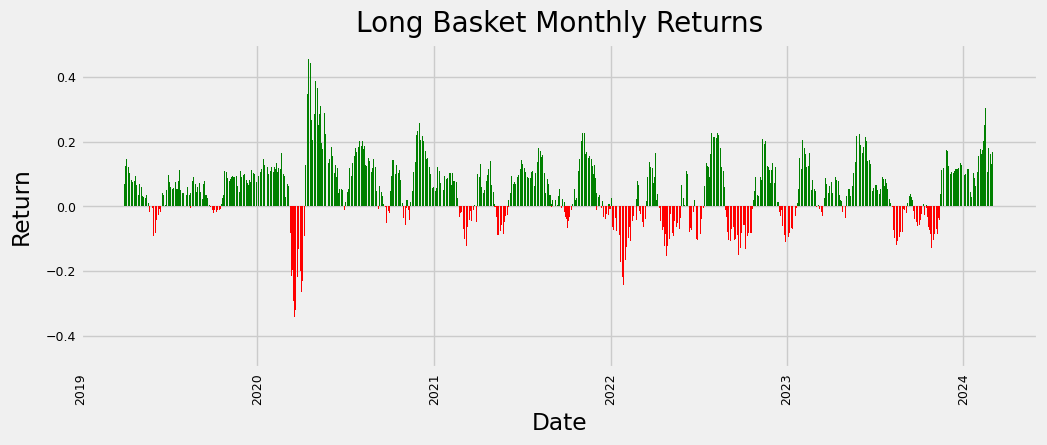

In [17]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

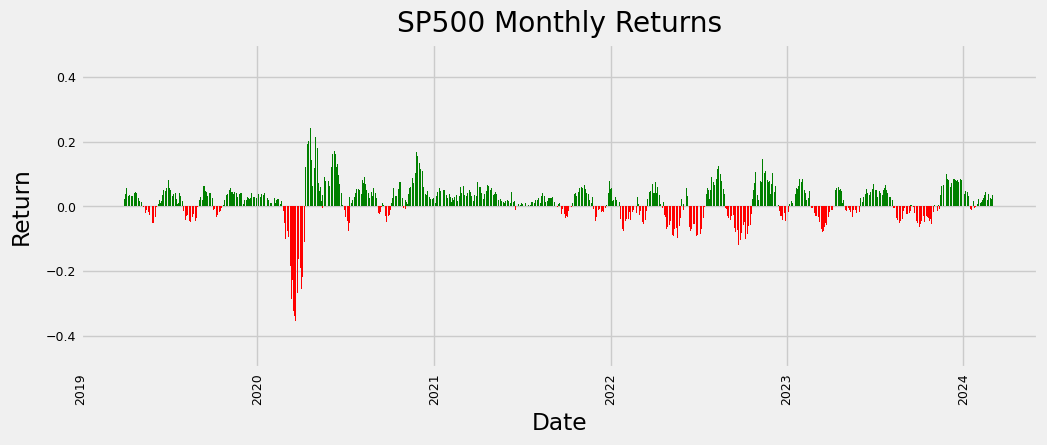

In [18]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

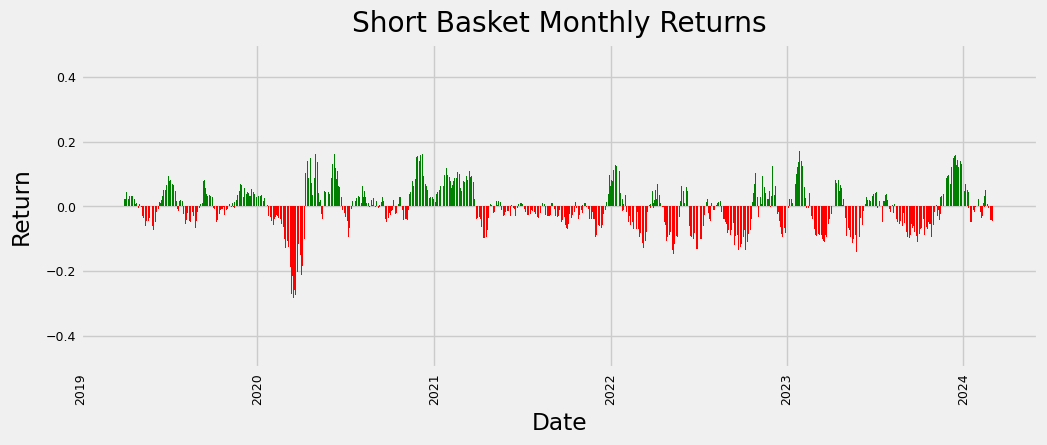

In [19]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Portfolio weights : 
#### My Efficient Frontier Program takes a basket of stocks and simulates over 200,000 times to find the arrangement of stock weights for our portfolio, that will return the highest earnings over risk-level.
#### You can find this program in the directory labeled Efficient_Frontier


# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [20]:
%%capture 
import os
import sys

# Getting the directory for the efficient frontier module: 
current_dir = os.getcwd()[:-17] # slicing out the last 14 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

"""
Im using %%capture to suppress the output of the cell.
"""

In [21]:
ef = EfficientFrontier(sp500[long_basket.index])
print('Annual Returns: Long Basket')
ef.calculate_portfolio() #Printing Annual Returns

Annual Returns: Long Basket
Ticker
TSLA    1.388214
MRNA    1.588831
NVDA    1.636770
SMCI    1.572177
NVR     1.238667
ENPH    1.583571
CMG     1.218756
BLDR    1.438255
AMD     1.541195
AZO     1.209289
dtype: float64


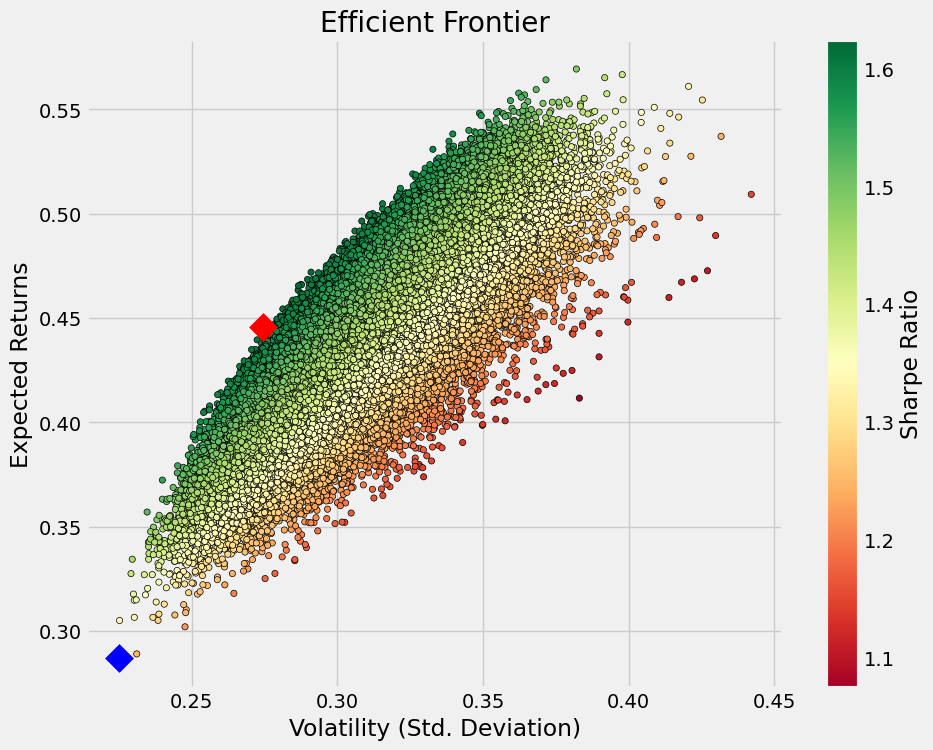

In [22]:
ef.plot_frontier() # Visualizes the simulations for our Long Basket portfolio
# With each dot representing a different portfolio, and the curve of the spread representing the efficient frontier

In [23]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.287094                  0.445914
Volatility                        0.224829                  0.274454
Sharpe Ratio                      1.276945                  1.624730
TSLA Weight                       0.025823                  0.041444
MRNA Weight                       0.054518                  0.136190
NVDA Weight                       0.025910                  0.234129
SMCI Weight                       0.018101                  0.110318
NVR Weight                        0.322323                  0.112652
ENPH Weight                       0.025413                  0.034265
CMG Weight                        0.253674                  0.015259
BLDR Weight                       0.016284                  0.042795
AMD Weight                        0.029338                  0.034119
AZO Weight                        0.228615                  0.238831


## Maximizing returns with our updated weights:

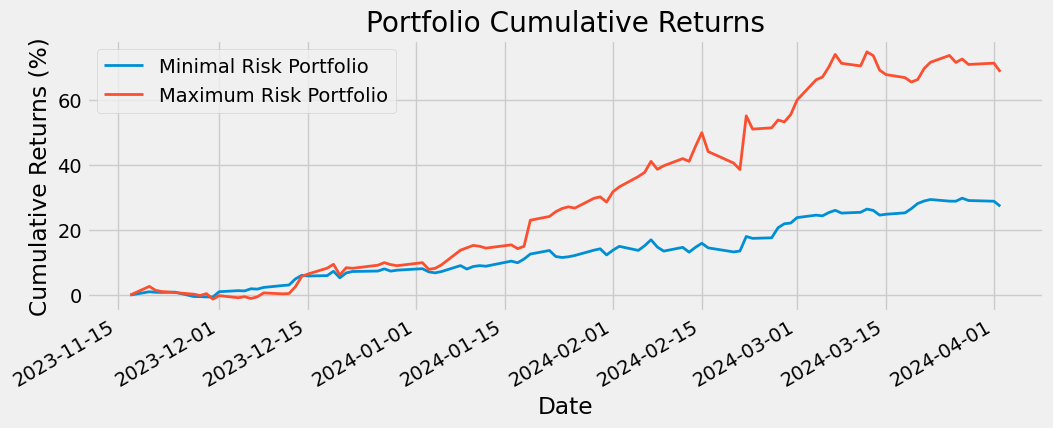

In [24]:

weights_minimal_risk = {
    'TSLA': 0.051118, 'MRNA': 0.101076, 'NVDA': 0.032128, 'SMCI': 0.010970,
    'NVR': 0.293823, 'ENPH': 0.004250, 'BLDR': 0.002243, 'CMG': 0.080609,
    'AZO': 0.377251, 'AMD': 0.046532
}

weights_maximum_risk = {
    'TSLA': 0.013270, 'MRNA': 0.155588, 'NVDA': 0.250389, 'SMCI': 0.150165,
    'NVR': 0.022550, 'ENPH': 0.073423, 'BLDR': 0.019092, 'CMG': 0.022661,
    'AZO': 0.244763, 'AMD': 0.048099
}

# Calculate daily portfolio returns for both scenarios
portfolio_returns_minimal_risk = (sp500[long_basket.index][-92:].pct_change() * pd.Series(weights_minimal_risk)).sum(axis=1)
portfolio_returns_maximum_risk = (sp500[long_basket.index][-92:].pct_change() * pd.Series(weights_maximum_risk)).sum(axis=1)

# Calculate cumulative returns to see the overall performance
cumulative_returns_minimal_risk = ((1 + portfolio_returns_minimal_risk).cumprod() - 1)*100
cumulative_returns_maximum_risk = ((1 + portfolio_returns_maximum_risk).cumprod() - 1)*100

# If you want to plot these
plt.figure(figsize=(11, 4))
cumulative_returns_minimal_risk.plot(label='Minimal Risk Portfolio', lw=2)
cumulative_returns_maximum_risk.plot(label='Maximum Risk Portfolio', lw=2)
plt.legend()
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.show()

In [25]:
print ("Max Risk portfolio returns:")
print (cumulative_returns_maximum_risk)
print ("Min Risk portfolio returns:")
print (cumulative_returns_minimal_risk)

print (f"Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_maximum_risk[-1]/weeks)

print (f"Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_minimal_risk[-1]/weeks)



Max Risk portfolio returns:
Date
2023-11-17     0.000000
2023-11-20     2.646628
2023-11-21     1.434917
2023-11-22     1.081172
2023-11-24     0.770097
                ...    
2024-03-26    71.430838
2024-03-27    72.488305
2024-03-28    70.814363
2024-04-01    71.211564
2024-04-02    68.575440
Length: 92, dtype: float64
Min Risk portfolio returns:
Date
2023-11-17     0.000000
2023-11-20     1.009625
2023-11-21     0.848885
2023-11-22     0.801476
2023-11-24     0.903833
                ...    
2024-03-26    28.815343
2024-03-27    29.753324
2024-03-28    29.026044
2024-04-01    28.814115
2024-04-02    27.264160
Length: 92, dtype: float64
Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date (19 weeks): 
3.6092337076236904
Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date (19 weeks): 
1.434955801640254


In [28]:
import json

output_dir = 'C:\\Users\\jeanb\\Documents\\GitHub\\Quantative-Finance-Repo\\Berry-Cox-Baskets\\output'
os.makedirs(output_dir, exist_ok=True)

# Define the full path for the JSON file
json_file_path = os.path.join(output_dir, 'portfolio_returns.json')

# Assuming 'portfolio_returns', 'cumulative_returns_maximum_risk', 'cumulative_returns_minimal_risk', and 'weeks'
# are the variables containing the data you want to output
output_data = {
    "Portfolio 1 Returns": portfolio_returns[-1],
    "Portfolio 1 Average Weekly Returns": portfolio_returns[-1] / weeks,
    "Max Risk Portfolio Returns": cumulative_returns_maximum_risk[-1],
    "Max Risk Portfolio Average Weekly Returns": cumulative_returns_maximum_risk[-1] / weeks,
    "Min Risk Portfolio Returns": cumulative_returns_minimal_risk[-1],
    "Min Risk Portfolio Average Weekly Returns": cumulative_returns_minimal_risk[-1] / weeks,
    "Difference in E.W Portfolio and MaxRisk Portfolio": cumulative_returns_maximum_risk[-1] - portfolio_returns[-1],
    
}

# Convert the data to a JSON string
json_data = json.dumps(output_data, indent=4)

# Write the JSON data to the specified file
with open(json_file_path, 'w') as json_file:
    json_file.write(json_data)

# Confirm the path where the file was saved
print(f"File saved to {json_file_path}")

File saved to C:\Users\jeanb\Documents\GitHub\Quantative-Finance-Repo\Berry-Cox-Baskets\output\portfolio_returns.json
